# Disentangled Embedded Topic Model

In [ ]:
# install gensim 4.0+
!pip uninstall gensim &> /dev/null
!pip install git+https://github.com/piskvorky/gensim.git@develop &> /dev/null

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/gensim-3.6.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/gensim/*
Proceed (y/n)? y
  Successfully uninstalled gensim-3.6.0
  Cloning https://github.com/piskvorky/gensim.git (to revision develop) to /tmp/pip-req-build-13_n81q5
  Running command git clone -q https://github.com/piskvorky/gensim.git /tmp/pip-req-build-13_n81q5
  Running command git submodule update --init --recursive -q
  Using cached Cython-0.29.23-cp37-cp37m-manylinux1_x86_64.whl (2.0 MB)
  Created wheel for gensim: filename=gensim-4.1.3.dev0-cp37-cp37m-linux_x86_64.whl size=25527724 sha256=acb7c145cf1239950df91264e79bbaad13223070d9542599aae9f63e90fabc95
  Stored in directory: /tmp/pip-ephem-wheel-cache-3jnwcjj6/wheels/11/72/a6/0dd367e7f454ac220ad58c2cb05065516b592ee71686e40d37
Successfully built gensim
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.24
   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# check cuda version
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import os
import glob
import time
import json
import random
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import gc # garbage collector

import hashlib
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import gensim
from gensim.models import FastText
print("gensim version", gensim.__version__)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# set working directory
# cwd = "drive/MyDrive/Topic Modeling" # Ximin
cwd = "drive/Shareddrives/AV_Twitter_Project/Topic Modeling" # Ran

# make exp path
exp_path = os.path.join(cwd, "exp", "etm_disentangled")
if not os.path.exists(exp_path):
    os.mkdir(exp_path)

In [ ]:
""" todo: add kl annealing and prior learning """

' todo: add kl annealing and prior learning '

## Filter AV and Lemmatize data
Keep most POS. Compute MD5 hash for every processed tweet

In [ ]:
def filter_av(df, idx_av, threshold):
    """ remove non-AV tweets from df """
    inference_cols = [col for col in df.columns if "prob" in col]
    av_cols = [inference_cols[i] for i in idx_av]
    
    # filter AV tweets by threshold
    df = df.assign(AV=df[av_cols].sum(axis=1))
    df = df.loc[df["AV"] > threshold]

    # remove av prob columns
    cols = [
        col for col in df.columns if \
        all(["prob" not in col, "mu" not in col, "std" not in col])
    ]
    df = df[cols]
    df = df.drop(columns=["text_y"])
    df = df.rename(columns={"text_x": "text"}).reset_index(drop=True)
    return df

def load_av_data(data_paths, idx_av, threshold):
    print(f"loading AV data with idx: {idx_av}, threshold: {threshold}...")
    df_av = []
    start_time = time.time()
    for i, data_path in enumerate(data_paths):
        filename = os.path.basename(data_path)
        df = pd.read_csv(data_path, lineterminator="\n")
        df_inference = pd.read_csv(
            data_path.replace("/raw_csv/", "/lda_bow_inference/"), lineterminator="\n"
        )
        df_sentiment = pd.read_csv(
            data_path.replace("/raw_csv/", "/sentiment/"), lineterminator="\n"
        )
        
        # filter av
        df = df.merge(df_inference, on="tweet_id", how="outer", copy=False)
        df = df.merge(df_sentiment, on="tweet_id", how="outer", copy=False)
        df = filter_av(df, idx_av, threshold)
        df_av.append(df)
        
        print(
            "{}, {}, time: {:.2f}, data size: {}".format(
            i, filename, time.time() - start_time, df.shape
            )
        )

    df_av = pd.concat(df_av)
    df_av = df_av.drop_duplicates(subset=["tweet_id"]).reset_index(drop=True)

    print(f"\nAV tweet size: {df_av.shape}, time: {time.time() - start_time:.2f}")
    gc.collect()
    return df_av

In [ ]:
def remove_tags(df):
    """ remove tweet-processor lib tags """
    # python does not allow $XXX$ symbols
    df = df.str.replace("$", "")
    df = df.str.replace("URL", "")
    df = df.str.replace("HASHTAG", "")
    df = df.str.replace("MENTION", "")
    df = df.str.replace("RESERVED", "")
    df = df.str.replace("EMOJI", "")
    df = df.str.replace("SMILEY", "")
    df = df.str.replace("NUMBER", "")
    return df

def hash_md5(text):
    return hashlib.md5(text.encode()).digest()

def lemmatize(
    doc, stop_words=STOP_WORDS, pos=["PROPN", "NOUN", "VERB"], 
    keywords=[], min_len=3
    ):
    """ 
    args:
        doc: spacy doc object
        pos (list): allowed part of speech, default=["PROPN", "NOUN", "VERB"]
        keywords (list): included keywords anyway, default=[]
        min_len (int): min number of letters in a word, default=3
    """
    tokens = [
        token.lemma_.lower() for token in doc \
        if ((token.pos_ in pos and len(token.lemma_) >= min_len) \
            or token.lemma_.lower() in keywords) \
            and (token.lemma_.lower() not in stop_words)
    ]
    return " ".join(tokens)

def preprocess(
    df, stop_words=STOP_WORDS, pos=["PROPN", "NOUN", "VERB"], 
    keywords=[], min_len=3, min_words=5
    ):
    text = remove_tags(df["tokens"].astype(str))
    text = text.str.replace("[^\w\s]", " ") # strip punctuations

    nlp = spacy.load(
        "en_core_web_sm", 
        enable=["tokenizer", "lemmatizer"],
        disable=["parser", "ner", "ent"], 
    )
    docs = list(nlp.pipe(text.tolist()))
    lemmas = [
        lemmatize(doc, stop_words, pos, keywords, min_len) for doc in docs
    ]

    df = df.assign(lemmas=lemmas)
    df = df.assign(num_lemmas=df["lemmas"].str.split().apply(len))

    # drop short text
    df = df.loc[df["num_lemmas"] >= min_words]

    # filter md5
    df = df.assign(md5=df["lemmas"].apply(hash_md5))
    df = df.drop_duplicates(subset="md5", keep="first")
    df = df.reset_index(drop=True)
    return df

In [ ]:
# load data
load_filtered = True
data_paths = glob.glob(os.path.join(cwd, "data/opinion_modeling/raw_csv/", "*.csv"))
av_data_path = os.path.join(cwd, "data/opinion_modeling/av_classification")
idx_av = [1, -2]
threshold = 0.3

if load_filtered:
    df = pd.read_csv(os.path.join(av_data_path, "av_tweets.csv"), lineterminator="\n")
    print(f"data size: {df.shape}")
else:
    df = load_av_data(data_paths, idx_av, threshold)

# save av data
if not load_filtered:
    df.to_csv(os.path.join(av_data_path, "av_tweets.csv"), index=False)

data size: (78597, 19)


In [ ]:
# preprocess
process_config = {
    "debug": False, 
    "pos": ["PROPN", "NOUN", "VERB", "ADJ", "ADV", "AUX", "INTJ", ], # pos to keep
    "keywords": ["autonomous", "av"],
    "min_len": 3, # min number of letters per word
    "min_words": 5
}

start_time = time.time()
df_processed = df.iloc[:10000] if process_config["debug"] else df
df_processed = preprocess(
    df_processed, 
    STOP_WORDS,
    process_config["pos"], 
    process_config["keywords"], 
    process_config["min_len"],
    process_config["min_words"]
)

print(f"processed data size: {df_processed.shape}, time: {time.time() - start_time:.2f}")

processed data size: (40080, 22), time: 68.18


In [ ]:
# check sentiment
# df_sample = df_processed.sort_values(by="positive", ascending=False)
# for i in range(20):
#     pprint(df_sample.iloc[i]["tokens"])
#     print(df_sample.iloc[i][["negative", "neutral", "positive"]])

## Load Fasttext embedding

In [ ]:
def load_fasttext(path):
    model = FastText.load(os.path.join(path, "model.m"))
    return model

In [ ]:
dim = 300
fasttext_path = os.path.join(
    cwd, "exp/fasttext", 
    f"sample_ratio_0.8_embedding_size_{dim}_window_5_min_count_3_lr_0.05_seed".format(dim)
)

fasttext_model = load_fasttext(fasttext_path)
print(fasttext_model)

FastText<vocab=74030, vector_size=300, alpha=0.05>


## Train topic model

In [ ]:
!pip install pyro-ppl &> /dev/null

In [ ]:
import math
from gensim.models import FastText

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import spacy
import torchtext
from collections import Counter, OrderedDict
from torchtext.vocab import Vocab
from torchtext.vocab import vocab as build_vocab
from torchtext.data.utils import get_tokenizer

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, TraceMeanField_ELBO, TraceEnum_ELBO, Trace_ELBO
from tqdm import trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


### 1. Data functions
Build vocab, train-test split

In [ ]:
class TwitterData(Dataset):
    def __init__(self, df, pipeline, max_vocab):
        super().__init__()
        self.df = df
        self.pipeline = pipeline
        self.max_vocab = max_vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]["lemmas"]
        
        sentiment = self.df.iloc[idx][
            ["negative", "neutral", "positive"]
        ].values.astype(np.float32)

        processed_text = torch.Tensor(self.pipeline(text)).long()
        sentiment = torch.from_numpy(sentiment)
        sentiment = 0.5 * (sentiment.dot(torch.Tensor([-1, 0, 1])) + 1)

        bow = torch.zeros(self.max_vocab)
        bow[processed_text] = 1
        bow = bow

        return (
            bow.to(device), 
            processed_text.to(device), 
            sentiment.to(device)
        )

def pad_collate(batch):
    """ pad sequence with zeros 

    returns:
        bow: bag of words vectors
        x_pad: padded token indices
        sentiment: sentiment values
        adj: fully connected adjacency matrices
    """
    # unpack data type
    bow = torch.stack([b[0] for b in batch])
    x = [b[1] for b in batch]
    sentiment = torch.stack([b[2] for b in batch])
    
    x_pad = pad_sequence(x, batch_first=True, padding_value=0).long()
    
    # make mask
    mask = [torch.ones(len(b[1])) for b in batch]
    mask = pad_sequence(mask, batch_first=True, padding_value=0).to(device)
    adj = mask.unsqueeze(-1) * mask.unsqueeze(-2)
    return bow, x_pad, sentiment, adj

def build_torchtext_vocab(docs, min_df=1, max_vocab=10000):
    """ 
    args:
        docs: list or df of tweet strings
        min_df: min doc frequency, default=1
        max_vocab_size: max vocab to include, default=10000

    returns:
        text_pipeline: tokenizing pipeline for dataset object
        vocab: torchtext vocab object
        ordered_dict: vocab dict and freq
    """
    tokenizer = get_tokenizer("basic_english")
    counter = Counter()
    for line in docs:
        counter.update(tokenizer(line))
    counter = counter.most_common(max_vocab)

    sorted_by_freq_tuples = sorted(counter, key=lambda x: x[1], reverse=True)
    ordered_dict = OrderedDict(sorted_by_freq_tuples)
    vocab = build_vocab(ordered_dict, min_freq=min_df)

    # add <unk> token and default index
    if "<unk>" not in vocab: vocab.insert_token("<unk>", 0)
    vocab.set_default_index(-1)
    vocab.set_default_index(vocab["<unk>"])
    
    # preprocess pipeline
    text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

    # make vocab dict
    df_vocab = pd.DataFrame(
        [[k, v, (ordered_dict[k] if k != "<unk>" else 0)] 
        for k, v in vocab.get_stoi().items()], 
        columns=["word", "index", "freq"]
    ).sort_values(by="word", ascending=True).reset_index(drop=True)
    return text_pipeline, vocab, df_vocab

def load_fasttext_embedding(vocab, fasttext_model):
    embedding_dim = fasttext_model.vector_size
    embedding_matrix = torch.zeros(len(vocab), embedding_dim)
    for word, i in vocab.get_stoi().items():
        embedding_vector = fasttext_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = torch.from_numpy(embedding_vector).to(torch.float32)
    return embedding_matrix

def train_test_split(
    df, embedding_dict, sample_ratio=0.99, train_ratio=0.8, batch_size=128, 
    min_df=3, max_vocab=10000, seed=0
    ):
    """
    args:
        sample_ratio: subsample dataset, default=0.99
        train_ratio: percent of train data, default=0.8
        batch_size: default=128
        max_df: max doc frequency, default=0.95
        min_df: min doc count, default=3,
        max_vocab: most frequent words, default=10000
    """
    np.random.seed(seed)
    
    # shuffle data
    df = df.sample(frac=1, random_state=seed)
    
    # subsample dataset
    num_samples = np.ceil(len(df) * sample_ratio).astype(int)
    df = df.iloc[:num_samples]
    
    # train-test split
    num_train = np.ceil(len(df) * train_ratio).astype(int)
    df_train = df.iloc[:num_train]
    df_test = df.iloc[num_train:]

    print(f"\ntrain size: {df_train.shape}, test_size: {df_test.shape}")
    
    pipeline, vocab, df_vocab = build_torchtext_vocab(
        df_train["lemmas"], min_df, max_vocab
    )
    
    # load embedding
    if embedding_dict is None:
        embedding_matrix = torch.empty(0)
        missing_words = 0
    else:
        assert isinstance(embedding_dict, FastText)
        print("load fasttext emebedding")
        embedding_matrix = load_fasttext_embedding(vocab, embedding_dict)
        missing_words = sum(embedding_matrix.abs().sum(1) == 0)

    # make loaders
    train_loader = DataLoader(
        TwitterData(df_train, pipeline, len(vocab), bow=True),
        batch_size=batch_size, shuffle=True, drop_last=True,
        collate_fn=pad_collate
    )
    test_loader = DataLoader(
        TwitterData(df_test, pipeline, len(vocab), bow=True),
        batch_size=batch_size, shuffle=False, drop_last=True,
        collate_fn=pad_collate
    )

    print("dictionary size: %d" % len(df_vocab["index"].unique()))
    print("pretrained embedding matrix size: {}, missing words: {}".format(
        embedding_matrix.shape, missing_words
    ))
    return train_loader, test_loader, df_vocab, embedding_matrix

### 2. Build models

In [ ]:
class TransformerConv(nn.Module):
    """ Graph convolution with multi-head attention """
    def __init__(
        self, 
        in_features, 
        out_features, 
        edge_features=1, 
        heads=1, 
        concat=True,
        dropout=0, 
        bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.edge_features = edge_features
        self.heads = heads
        self.concat = concat
        self.dropout = dropout
        self.bias = bias
        
        # attention weights
        self.lin_key = nn.Linear(in_features, heads * out_features)
        self.lin_query = nn.Linear(in_features, heads * out_features)
        self.lin_value = nn.Linear(in_features,  heads * out_features)
        
        # graph weights
        self.lin_edge = nn.Linear(edge_features, heads * out_features, bias=False)
        if concat:
            self.lin_root = nn.Linear(in_features, heads * out_features)
        else:
            self.lin_root = nn.Linear(in_features, out_features)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        self.lin_edge.reset_parameters()
        self.lin_root.reset_parameters()

    def forward(self, x, adj):
        """ Assume same graph size
        args:
            x: [batch_size, num_nodes, node_features]
            adj: [batch_size, num_nodes, num_nodes, edge_features]

        returns:
            out: [batch_size, num_nodes, heads * out_features]
        """
        if adj.shape[1] != adj.shape[2]:
            raise ValueError("Adjacency matrix is not square matrix")
        if len(adj.shape) == 3:
            adj = adj.unsqueeze(-1)
        batch_size, num_nodes = x.shape[0], x.shape[1]

        # get neighbour message
        out = self.message(x, adj)
        if self.concat:
            out = out.view(batch_size, num_nodes, self.heads * self.out_features)
        else:
            out = out.mean(dim=2)
        
        # add root node
        out += self.lin_root(x)
        return out

    def message(self, x, adj):
        """ Calculate message from neighbours
        args:
            x: [batch_size, num_nodes, node_features]
            adj: [batch_size, num_nodes, num_nodes, edge_features]

        returns:
            out: [batch_size, node_dim, heads, out_features]
        """
        batch_size, num_nodes = x.shape[0], x.shape[1]
        A = 1 * (adj.sum(-1).abs() > 0).unsqueeze(-1)

        query = self.lin_query(x).view(batch_size, num_nodes, self.heads, self.out_features)
        key = self.lin_key(x).view(batch_size, num_nodes, self.heads, self.out_features)
        edge_attr = self.lin_edge(adj).view(batch_size, num_nodes, num_nodes, self.heads, self.out_features)

        # add edge features
        key = A.unsqueeze(-1) * key.unsqueeze(2) + edge_attr
        
        # compute attention
        alpha = torch.sum(query.unsqueeze(2) * key, dim=-1) / math.sqrt(self.out_features)
        mask = -1e10 * (1 - A) # mask non neighbours with -inf
        alpha = torch.softmax(alpha + mask, dim=2)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        # apply attention
        value = self.lin_value(x).view(batch_size, num_nodes, self.heads, self.out_features)
        out = A.unsqueeze(-1) * value.unsqueeze(1) + edge_attr
        out *= alpha.unsqueeze(-1)
        return out.sum(2)

    def __repr__(self):
        return "{}(in_features={}, out_features={}, edge_features={}, heads={}, dropout={})".format(
            self.__class__.__name__,
            self.in_features,
            self.out_features,
            self.edge_features,
            self.heads,
            self.dropout
        )


In [ ]:
class MLPEncoder(nn.Module):
    def __init__(
        self, vocab_size, num_topics, embedding_dim, hidden, dropout,
        use_embedding=True, embedding_matrix=None, train_embedding=True
        ):
        super().__init__()
        self.use_embedding = use_embedding

        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)

        input_dim = embedding_dim if use_embedding else vocab_size
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.zmu = nn.Linear(hidden, num_topics)
        self.zlv = nn.Linear(hidden, num_topics)
        self.smu = nn.Linear(hidden, 1)
        self.slv = nn.Linear(hidden, 1)
        
        self.drop = nn.Dropout(dropout) 

        if embedding_matrix is not None:
            self.word_embedding.weight.data = embedding_matrix
        self.word_embedding.weight.requires_grad = train_embedding

    def forward(self, x):
        # avg pool doc embedding 
        if self.use_embedding:
            x = x.matmul(self.word_embedding.weight) / x.sum(-1, keepdims=True)

        h = F.softplus(self.fc1(x))
        h = self.drop(h)
        h = F.softplus(self.fc2(h))
        
        # infer topic
        z_mu = self.zmu(h)
        z_lv = self.zlv(h)
        z_sd = (0.5 * z_lv).exp() 
        
        # infer sentiment
        s_mu = self.smu(h)
        s_lv = self.slv(h)
        s_sd = (0.5 * s_lv).exp()
        return z_mu, z_sd, s_mu, s_sd


class GraphEncoder(nn.Module):
    def __init__(
        self, vocab_size, num_topics, embedding_dim, hidden, dropout,
        embedding_matrix=None, train_embedding=True
        ):
        super().__init__()
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)

        self.gcn1 = TransformerConv(embedding_dim, hidden, heads=1)
        self.fc1 = nn.Linear(hidden, hidden)
        self.zmu = nn.Linear(hidden, num_topics)
        self.zlv = nn.Linear(hidden, num_topics)
        self.smu = nn.Linear(hidden, 1)
        self.slv = nn.Linear(hidden, 1)

        self.drop = nn.Dropout(dropout) 

        if embedding_matrix is not None:
            self.word_embedding.weight.data = embedding_matrix
        self.word_embedding.weight.requires_grad = train_embedding

    def forward(self, x, adj):
        x = self.word_embedding(x)

        h = F.softplus(self.gcn1(x, adj))
        h = torch.mean(h, dim=1)
        h = self.drop(h)
        h = F.softplus(self.fc1(h))

        # infer topic
        z_mu = self.zmu(h)
        z_lv = self.zlv(h)
        z_sd = (0.5 * z_lv).exp() 
        
        # infer sentiment
        s_mu = self.smu(h)
        s_lv = self.slv(h)
        s_sd = (0.5 * s_lv).exp()
        return z_mu, z_sd, s_mu, s_sd


class Decoder(nn.Module):
    def __init__(
        self, vocab_size, num_topics, embedding_dim
        ):
        super().__init__()        
        # topic params
        self.topic_embedding = nn.Linear(embedding_dim, num_topics, bias=False)
        self.log_freq = nn.Parameter(torch.randn(1, vocab_size), requires_grad=True) 
        self.sentiment_embedding = nn.Linear(embedding_dim, num_topics, bias=False)   
        
        # sentiment params
        self.y_alpha = nn.Linear(num_topics, 1, bias=True)
        self.y_beta = nn.Linear(num_topics, 1, bias=True)
        self.y_alpha_s = nn.Parameter(torch.randn(1, num_topics))
        self.y_beta_s = nn.Parameter(torch.randn(1, num_topics))
        
        nn.init.xavier_normal_(self.log_freq)
        nn.init.xavier_normal_(self.y_alpha_s)
        nn.init.xavier_normal_(self.y_beta_s)

    def forward(self, z, s, word_embedding):
        # unnormalized topic-term
        topic_term = self.beta(word_embedding, s)
    
        topic_term = torch.softmax(topic_term, dim=-1)
        p_words = z.unsqueeze(-2).matmul(topic_term).squeeze(-2)

        # sentiment params
        alpha, beta = self.y_dist(z, s)
        return p_words, alpha, beta

    def beta(self, word_embedding, s):
        topic_term = self.topic_embedding(word_embedding).t() + self.log_freq        
        sentiment_term = self.sentiment_embedding(word_embedding).t()
        topic_term = (
            topic_term.unsqueeze(0) + \
            s.unsqueeze(-1) * sentiment_term.unsqueeze(0)
        )
        return topic_term

    def y_dist(self, z, s):
        alpha = torch.exp(
            self.y_alpha(z) + s * z.matmul(self.y_alpha_s.t()**2)
        ).view(-1)
        beta = torch.exp(
            self.y_beta(z) - s * z.matmul(self.y_beta_s.t()**2)
        ).view(-1)
        return alpha, beta


class ETM(nn.Module):
    def __init__(
        self, vocab_size, num_topics, embedding_dim, hidden, 
        dropout, batch_norm, embedding_matrix=None, train_embedding=True, 
        encoder_model="gnn", seed=0
        ):
        super().__init__()
        torch.manual_seed(seed)
        assert encoder_model in ["bow", "w2v", "gnn"]
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.embedding_dim = (
            embedding_dim if embedding_matrix is None
            else embedding_matrix.shape[1]
        )
        self.encoder_model = encoder_model

        if encoder_model == "gnn":
            self.encoder = GraphEncoder(
                vocab_size, num_topics, self.embedding_dim, hidden, dropout, 
                embedding_matrix, train_embedding
            )
        else:
            use_embedding = True if "w2v" else False
            self.encoder = MLPEncoder(
                vocab_size, num_topics, self.embedding_dim, hidden, dropout,
                use_embedding, embedding_matrix, train_embedding
            )

        self.decoder = Decoder(
            vocab_size, num_topics, self.embedding_dim
        )

    def model(self, data):
        """ generative process """ 
        bow, docs, sentiment, adj = data 
        embedding = self.encoder.word_embedding.weight

        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # topic prior
            z_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            z_scale = docs.new_ones((docs.shape[0], self.num_topics))
            z = pyro.sample(
                "z", dist.Normal(z_loc, z_scale).to_event(1)
            )
            z = F.softmax(z, -1)

            # sentiment prior
            s_loc = docs.new_zeros((docs.shape[0], 1))
            s_scale = docs.new_ones((docs.shape[0], 1))
            s = pyro.sample(
                "s", dist.Normal(s_loc, s_scale).to_event(1)
            )

            # generate words and sentiment
            word_count, y_alpha, y_beta = self.decoder(z, s, embedding)
            
            total_count = int(docs.sum(-1).max()) # multinomial requirement
            pyro.sample(
                "obs_word",
                dist.Multinomial(total_count, word_count),
                obs=bow
            )

            pyro.sample(
                "obs_sentiment",
                dist.Beta(y_alpha, y_beta),
                obs=sentiment
            )

    def guide(self, data):
        """ inference process """
        bow, docs, sentiment, adj = data 

        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            if self.encoder_model == "gnn":
                z_mu, z_sd, s_mu, s_sd = self.encoder(docs, adj)
            else:
                z_mu, z_sd, s_mu, s_sd = self.encoder(bow)

            z = pyro.sample(
                "z", dist.Normal(z_mu, z_sd).to_event(1)
            )

            s = pyro.sample(
                "s", dist.Normal(s_mu, s_sd).to_event(1)
            )

    def beta(self, s):
        """ construct sentiment conditioned topic term matrix
        
        args:
            s (float): sentiment factor value [-inf, inf]
        
        returns:
            topic_term: topic term matrix [num_topics, num_vocab] 
        """
        s = s * torch.ones(1, 1).to(device)

        with torch.no_grad():
            embedding = self.encoder.word_embedding.weight.data
            topic_term = self.decoder.beta(embedding, s)
        return topic_term.squeeze(0).cpu().detach()

    def y(self, query):
        """ get sentiment distributions for each query 

        args:
            query (list): sentiment query values
        
        returns:
            mu: sentiment means [num_query, num_topics]
            sd: sentiment stds [num_query, num_topics]
        """
        mu = torch.zeros(len(query), self.num_topics).to(device)
        sd = torch.zeros(len(query), self.num_topics).to(device)
        for i, s in enumerate(query):
            with torch.no_grad():
                z = torch.eye(self.num_topics).to(device)
                s = s * torch.ones(self.num_topics, 1).to(device)
                alpha, beta = self.decoder.y_dist(z, s)

                beta_dist = dist.Beta(alpha, beta)
                mu_ = beta_dist.mean.view(-1)
                sd_ = beta_dist.variance.sqrt().view(-1)

                # transform stats
                mu_ = 2 * mu_ - 1
                sd_ = 2 * sd_
            
            mu[i] = mu_
            sd[i] = sd_

        return mu.cpu().detach(), sd.cpu().detach()

### 3. Metrics and visualization utils

In [ ]:
def get_top_words(topic_term, df_vocab, topk=20):
    """ top k words in each topic """
    df_vocab = df_vocab.sort_values(by="index")
    num_topics = len(topic_term)

    top_words = []
    for i in range(num_topics):
        idx = topic_term[i].argsort()[:-topk - 1:-1]
        top_words.append([df_vocab["word"].iloc[i] for i in idx])

    return top_words

def get_topic_coherence(loader, topic_term, df_vocab, topk=20):
    """ mutual info based on topk words 
    
    args:
        loader: torch dataloader
        topic_term: topic-term torch tensor
        df_vocab:
        topk: topk words to use, default=20
    """

    # find the most frequent word index in each topic
    num_topics = len(topic_term)
    topic_term_index = torch.stack(
        [topic_term[i].argsort(descending=True)[:topk] for i in range(num_topics)]
    ).long()
    
    # get full doc-term matrix
    doc_term = torch.cat([d[0].cpu() for d in loader], dim=0) # use bow
    num_docs = doc_term.shape[0]
    
    # word occurrance prob
    p_i = doc_term.sum(0) / num_docs
    
    # calculate mutual info
    TC = torch.zeros(num_topics)
    for i in range(topk):
        for j in range(i+1, topk):
            p_ij = torch.sum(
                (doc_term[:, topic_term_index[:, i]] + \
                doc_term[:, topic_term_index[:, j]]) > 0, 
            dim=0) / num_docs

            num = torch.log(p_ij + 1e-10) - \
                torch.log(p_i[topic_term_index[:, i]] + 1e-10) - \
                torch.log(p_i[topic_term_index[:, j]] + 1e-10)
            dnm = -torch.log(p_ij + 1e-10)
            TC += num / dnm
    
    return TC.mean().data.item()

def get_topic_diversity(topic_term):
    """ number of unique words in topics """
    num_topics = len(topic_term)

    word_list = []
    count = 0
    for i in range(num_topics):
        for word in topic_term[i]:
            word_list.append(word)
            count += 1
    word_list = list(set(word_list))
    TD = len(word_list) / count
    return TD

def get_sentiment_diversity(topic_sentiment):
    d = torch.pow(
        topic_sentiment.unsqueeze(-1) - topic_sentiment.unsqueeze(-2), 2
    )
    return d.mean().data.numpy()

### 4. Plotting functions

In [ ]:
def plot_history(df_history, show=False):
    if show:
        %matplotlib inline
    else:
        %matplotlib notebook
    df_train_history = df_history.loc[df_history["train"] == "train"]
    df_test_history = df_history.loc[df_history["train"] == "test"]

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(df_train_history["epoch"] + 1, df_train_history["elbo"], "-o", label="Train")
    ax.plot(df_test_history["epoch"] + 1, df_test_history["elbo"], "-o", label="Test")
    ax.grid()
    ax.legend()

    if show:
        plt.show()
    return fig

def plot_topic_term(topic_term, df_vocab, topk=20, show=False):
    if show:
        %matplotlib inline
    else:
        %matplotlib notebook
    
    df_vocab = df_vocab.sort_values(by="index")
    num_topics = len(topic_term)
    n_col = min(num_topics, 5)
    n_row = np.ceil(num_topics / 5).astype(int)

    fig, ax = plt.subplots(n_row, n_col, figsize=(15, 5*n_row), sharex=True)
    ax = np.ravel(ax)
    for i in range(num_topics):
        idx = topic_term[i].argsort()[::-1][:topk]
        top_words = [df_vocab["word"].iloc[i] for i in idx]
        weights = topic_term[i, idx]

        ax[i].barh(top_words, weights, height=0.7)
        ax[i].set_title(f'Topic {i +1}', fontdict={'fontsize': 12})
        ax[i].invert_yaxis()
        ax[i].tick_params(axis='both', which='major', labelsize=12)
        for j in 'top right left'.split():
            ax[i].spines[j].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)

    if show:
        plt.show()
    return fig

def plot_topic_sentiment(mu, sd, query, show=False):
    """ plot topic sentiment for each query value """
    if show:
        %matplotlib inline
    else:
        %matplotlib notebook

    num_topics = mu.shape[1]

    fig, ax = plt.subplots(1, len(query), figsize=(15, 5))
    for i, s in enumerate(query):
        ax[i].plot(np.arange(num_topics) + 1, mu[i], "o")
        ax[i].errorbar(
            np.arange(num_topics) + 1, 
            mu[i], 
            yerr=sd[i]
        )
        ax[i].set_ylim([-1, 1])
        ax[i].set_xlabel("Topic")
        ax[i].set_ylabel(f"Sentiment {s}")
        ax[i].grid()

    plt.tight_layout()
    
    if show:
        plt.show()
    return fig

### 5. Training functions

In [ ]:
def run_epoch(model, loader, train=True, debug=False):
    """ pass data through model 

    args:
        model: 
        loader: train or test dataloader
        train: train mode, default=True
        debug: default=False
    """
    stats = []
    for i, data_batch in enumerate(loader):
        if train:
            loss = model.step(data_batch)
        else:
            loss = model.evaluate_loss(data_batch)
        
        stats.append({"elbo": loss / len(data_batch[0])})

        if debug:
            break

    stats = pd.DataFrame(stats).mean(0).to_dict()
    stats.update({"train": "train" if train else "test"})
    return stats

def main(df, embedding_dict, config):
    torch.manual_seed(config["seed"])
    pyro.set_rng_seed(config["seed"])
    pyro.clear_param_store()
    torch.cuda.empty_cache()

    train_loader, test_loader, df_vocab, embedding_matrix = train_test_split(
        df, 
        embedding_dict,
        config["sample_ratio"],
        config["train_ratio"],
        config["batch_size"],
        config["min_df"],
        config["max_vocab"],
        config["seed"],
    )
    gc.collect() # collect cache

    model = ETM(
        vocab_size=len(df_vocab["index"].unique()),
        num_topics=config["num_topics"],
        embedding_dim=config["embedding_dim"],
        hidden=config["hidden_dim"],
        dropout=config["dropout"],
        batch_norm=config["batch_norm"],
        embedding_matrix=embedding_matrix,
        train_embedding=config["train_embedding"],
        encoder_model=config["encoder_model"],
        seed=config["seed"]
    )
    model.to(device)
    print(f"using device: {device}\n")

    optimizer = pyro.optim.Adam(
        {
            "lr": config["lr"],
            "betas": config["betas"]
        }
    )
    svi = SVI(
        model.model, 
        model.guide, 
        optimizer, 
        loss=Trace_ELBO()
    )
    
    # train
    start_time = time.time()
    bar = trange(config["epochs"])
    history = []
    for e in bar: 
        train_stats = run_epoch(svi, train_loader, train=True, debug=config["debug"])
        test_stats = run_epoch(svi, test_loader, train=False, debug=config["debug"])

        # compute topic diversity
        topic_term = model.beta(0).data.numpy()
        td = get_topic_diversity(get_top_words(topic_term, df_vocab))
        train_stats.update({"td": td, "epoch": e, "time": time.time() - start_time})
        test_stats.update({"td": td, "epoch": e, "time": time.time() - start_time})
        
        # collect stats
        history.append(train_stats)
        history.append(test_stats)
        
        bar.set_postfix(
            elbo='{:.2f}'.format(train_stats["elbo"]), 
            time="{:.2f}".format(np.round(time.time() - start_time, 2))
        )
        
        if config["debug"] and e > 0:
            break
    
    print(f"\ntrain time: {(time.time() - start_time):.2f}")

    df_history = pd.DataFrame(history)
    
    if config["save"]:
        # make save path
        save_path = os.path.join(
            exp_path,
            "num_topics_{}_embedding_dim_{}_hidden_dim_{}_sample_ratio_{}"
            "_min_df_{}_max_vocab_{}_dropout_{}_batch_norm_{}_train_embedding_{}"
            "_encoder_model_{}_batch_size_{}_lr_{}_seed_{}".format(
                config["num_topics"],
                model.embedding_dim,
                config["hidden_dim"],
                config["sample_ratio"],
                config["min_df"],
                config["max_vocab"],
                config["dropout"],
                config["batch_norm"],
                config["train_embedding"],
                config["encoder_model"],
                config["batch_size"],
                config["lr"],
                config["seed"]
            )
        )
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        # save config
        with open(os.path.join(save_path, "args.json"), "w") as f:
            json.dump(config, f)
        
        # save history
        df_history.to_csv(os.path.join(save_path, "history.csv"), index=False)

        # save vocab
        df_vocab.to_csv(os.path.join(save_path, "vocab.csv"), index=False)

        # save model
        torch.save(model.state_dict(), os.path.join(save_path, "model.pth"))
        
        # save history fig
        fig_history = plot_history(df_history, show=False)
        fig_history.savefig(os.path.join(save_path, "history.png"), dpi=100)

        # save topic-term fig
        query = [-1, 0, 1]
        topk = 20
        for q in query:
            topic_term = model.beta(q).data.numpy()
            fig_topic = plot_topic_term(topic_term, df_vocab, topk, show=False)
            fig_topic.savefig(os.path.join(save_path, f"topic_term_{q}.png"), dpi=100)
        
        # save topic-sentiment fig
        y_mu, y_std = model.y(query)
        fig_sentiment = plot_topic_sentiment(y_mu, y_std, query, show=False)
        fig_sentiment.savefig(os.path.join(save_path, "topic_sentiment.png"), dpi=100)
        
        plt.clf(); plt.close("all")
    
    print(f"done, results saved: {config['save']}")
    return model, df_vocab, df_history

### 6. Manual training

In [ ]:
config = {
    "seed": 0,
    # data config
    "sample_ratio": 0.8, # sub sample dataset [0.5, 0.8]
    "train_ratio": 0.8, 
    "batch_size": 512, 
    "min_df": 5, # min doc count [2, 5]
    "max_vocab": 10000, # most freq words
    # model_config
    "num_topics": 4,
    "embedding_dim": 300, # [50, 300]
    "hidden_dim": 200, 
    "dropout": 0,
    "batch_norm": False,
    "train_embedding": True,
    "encoder_model": "gnn", # ["bow", "w2v", "gnn"] ["w2v", "gnn"]
    # train config
    "lr": 1e-3,
    "betas": (0.9, 0.99), # Adam optimizer momentum
    "epochs": 1,
    "debug": True,
    "save": True,
}

model, df_vocab, df_history = main(df_processed, fasttext_model, config)
# model, df_vocab, df_history = main(df_processed, None, config)


train size: (25652, 22), test_size: (6412, 22)
load fasttext emebedding
dictionary size: 4385
pretrained embedding matrix size: torch.Size([4385, 300]), missing words: 0
using device: cuda:0



100%|██████████| 1/1 [00:01<00:00,  1.79s/it, elbo=75.15, time=1.79]


train time: 1.80


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done, results saved: True


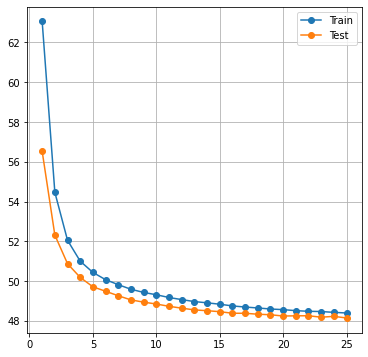

In [ ]:
# plot learning curve
fig = plot_history(df_history, show=True)

sentiment=-1


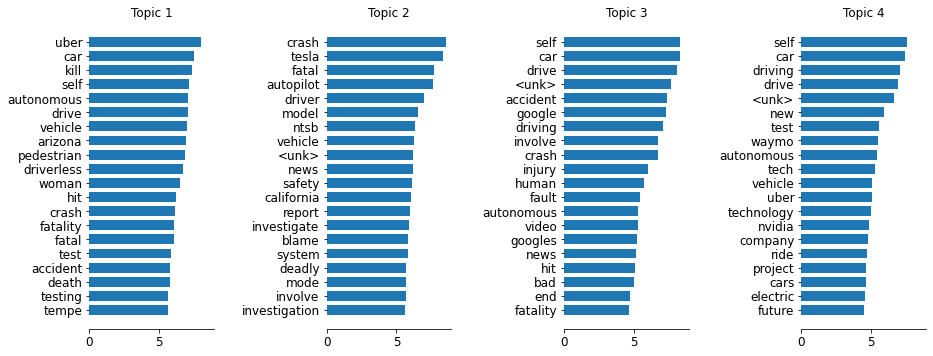

sentiment=0


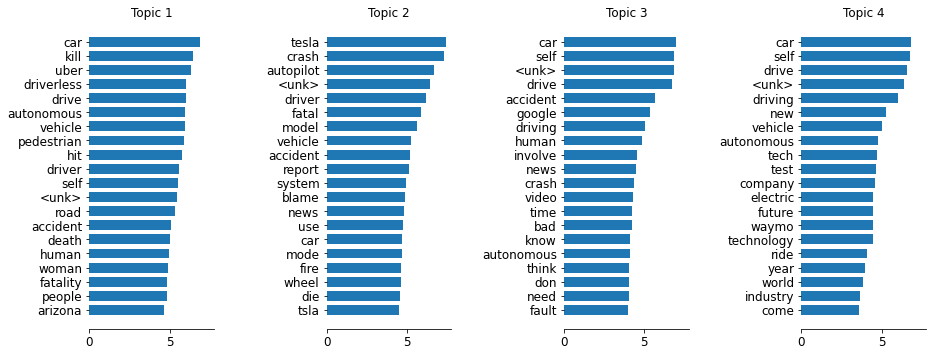

sentiment=1


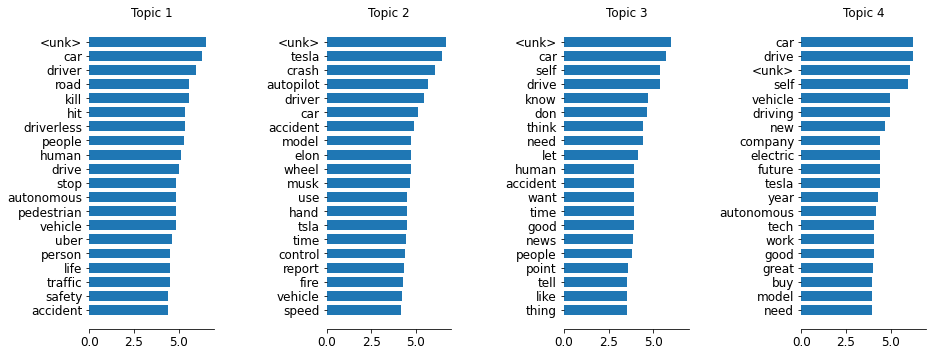

In [ ]:
# plot topic term
query = 1
print(f"sentiment=-{query}")
topic_term = model.beta(-query).numpy()
fig = plot_topic_term(topic_term, df_vocab, topk=20, show=True)

print("sentiment=0")
topic_term = model.beta(0).numpy()
fig = plot_topic_term(topic_term, df_vocab, topk=20, show=True)

print(f"sentiment={query}")
topic_term = model.beta(query).numpy()
fig = plot_topic_term(topic_term, df_vocab, topk=20, show=True)

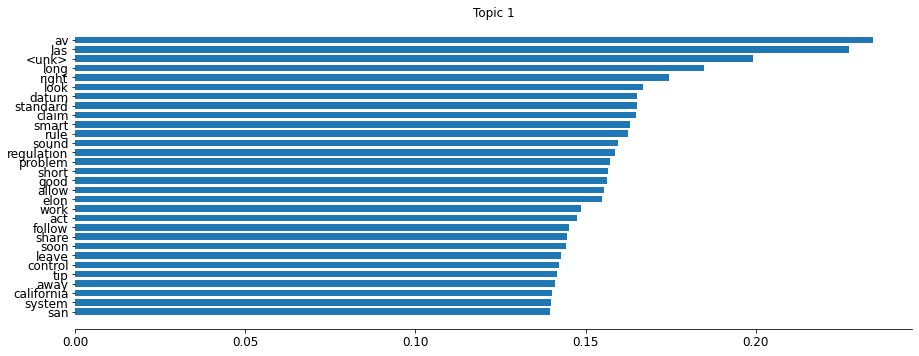

In [ ]:
# plot background topic_term
topic_bias = model.decoder.log_freq.data.cpu().numpy()
fig = plot_topic_term(topic_bias, df_vocab, topk=30, show=True)

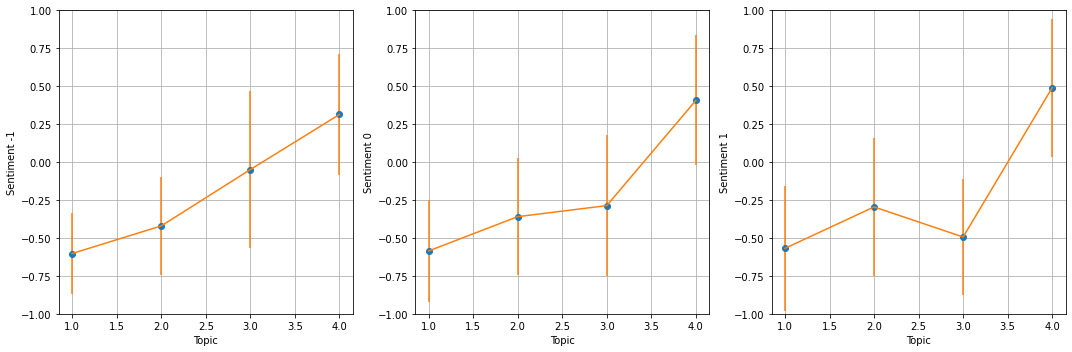

In [ ]:
# plot sentiment dist
query = [-1, 0, 1]
ts_mu, ts_sd = model.y(query)
ts_mu = ts_mu.numpy()
ts_sd = ts_sd.numpy()

fig = plot_topic_sentiment(ts_mu, ts_sd, query, show=True)

### 6. Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
def grid_search(df, embedding_dict, param_grid, debug=False):

    # if colab disconnected 
    # param_grid = list(param_grid)[11:]

    print(f"grid search, num_grids: {len(param_grid)}...")
    
    for i, params in enumerate(param_grid):
        print("\n", i, params)

        config = {
            "seed": params["seed"],
            # data config
            "sample_ratio": params["sample_ratio"], # sub sample dataset 
            "train_ratio": 0.8, 
            "batch_size": params["batch_size"],
            "min_df": params["min_df"], # min doc count
            "max_vocab": params["max_vocab"], # most freq words
            # model_config
            "num_topics": params["num_topics"],
            "embedding_dim": params["embedding_dim"],
            "hidden_dim": params["hidden_dim"],
            "dropout": params["dropout"],
            "batch_norm": params["batch_norm"],
            "train_embedding": params["train_embedding"],
            "encoder_model": params["encoder_model"], # ["bow", "w2v", "gnn"]
            # train config
            "lr": params["lr"],
            "betas": (0.9, 0.99), # Adam optimizer momentum
            "epochs": params["epochs"],
            "debug": debug,
            "save": True,
        }

        main(df, embedding_dict, config)

        if debug and i > 0: 
            break

In [ ]:
param_grid = ParameterGrid(
    {
        "seed": [0],
        # data config
        "sample_ratio": [0.8], # sub sample dataset 
        "train_ratio": [0.8], 
        "batch_size": [512],
        "min_df": [5], # min doc count
        "max_vocab": [10000], # most freq words
        # model_config
        "num_topics": [4, 6, 8, 10],
        "embedding_dim": [300],
        "hidden_dim": [200],
        "dropout": [0],
        "batch_norm": [False],
        "train_embedding": [True],
        "encoder_model": ["gnn"], # ["bow", "w2v", "gnn"]
        # train config
        "lr": [1e-3],
        "betas": [(0.9, 0.99)], # Adam optimizer momentum
        "epochs": [25],
    }
)

grid_search(df_processed, fasttext_model, param_grid, debug=False)

grid search, num_grids: 4...

 0 {'batch_norm': False, 'batch_size': 512, 'betas': (0.9, 0.99), 'dropout': 0, 'embedding_dim': 300, 'encoder_model': 'gnn', 'epochs': 25, 'hidden_dim': 200, 'lr': 0.001, 'max_vocab': 10000, 'method': 'etm', 'min_df': 5, 'num_topics': 4, 'sample_ratio': 0.8, 'seed': 0, 'train_embedding': True, 'train_ratio': 0.8, 'use_sentiment': True}

train size: (25652, 22), test_size: (6412, 22)
load fasttext emebedding
dictionary size: 4385
pretrained embedding matrix size: torch.Size([4385, 300]), missing words: 0
using device: cuda:0



100%|██████████| 25/25 [23:52<00:00, 57.29s/it, elbo=48.43, time=1432.15]


train time: 1432.16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done, results saved: True

 1 {'batch_norm': False, 'batch_size': 512, 'betas': (0.9, 0.99), 'dropout': 0, 'embedding_dim': 300, 'encoder_model': 'gnn', 'epochs': 25, 'hidden_dim': 200, 'lr': 0.001, 'max_vocab': 10000, 'method': 'etm', 'min_df': 5, 'num_topics': 6, 'sample_ratio': 0.8, 'seed': 0, 'train_embedding': True, 'train_ratio': 0.8, 'use_sentiment': True}

train size: (25652, 22), test_size: (6412, 22)
load fasttext emebedding
dictionary size: 4385
pretrained embedding matrix size: torch.Size([4385, 300]), missing words: 0
using device: cuda:0



100%|██████████| 25/25 [24:00<00:00, 57.62s/it, elbo=48.45, time=1440.53]


train time: 1440.54


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done, results saved: True

 2 {'batch_norm': False, 'batch_size': 512, 'betas': (0.9, 0.99), 'dropout': 0, 'embedding_dim': 300, 'encoder_model': 'gnn', 'epochs': 25, 'hidden_dim': 200, 'lr': 0.001, 'max_vocab': 10000, 'method': 'etm', 'min_df': 5, 'num_topics': 8, 'sample_ratio': 0.8, 'seed': 0, 'train_embedding': True, 'train_ratio': 0.8, 'use_sentiment': True}

train size: (25652, 22), test_size: (6412, 22)
load fasttext emebedding
dictionary size: 4385
pretrained embedding matrix size: torch.Size([4385, 300]), missing words: 0
using device: cuda:0



100%|██████████| 25/25 [24:07<00:00, 57.90s/it, elbo=48.55, time=1447.50]


train time: 1447.51


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done, results saved: True

 3 {'batch_norm': False, 'batch_size': 512, 'betas': (0.9, 0.99), 'dropout': 0, 'embedding_dim': 300, 'encoder_model': 'gnn', 'epochs': 25, 'hidden_dim': 200, 'lr': 0.001, 'max_vocab': 10000, 'method': 'etm', 'min_df': 5, 'num_topics': 10, 'sample_ratio': 0.8, 'seed': 0, 'train_embedding': True, 'train_ratio': 0.8, 'use_sentiment': True}

train size: (25652, 22), test_size: (6412, 22)
load fasttext emebedding
dictionary size: 4385
pretrained embedding matrix size: torch.Size([4385, 300]), missing words: 0
using device: cuda:0



100%|██████████| 25/25 [24:05<00:00, 57.84s/it, elbo=48.71, time=1445.98]


train time: 1445.99


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

done, results saved: True


## Model selection
Compare models based on metrics.

In [ ]:
def build_vocab_from_df(df_vocab):  
    df_vocab = df_vocab.sort_values(by="index")
    
    # replace nan, this is a bug from preprocessing above
    num_nan = sum(df_vocab["word"].isnull())
    df_vocab["word"].loc[df_vocab["word"].isnull()] = [f"nan_{i}" for i in range(num_nan)]

    tokens = df_vocab["word"].tolist()
    
    # build torchtext vocab
    from torchtext._torchtext import Vocab as VocabPybind
    vocab = VocabPybind(tokens, None)
    vocab = Vocab(vocab)
    
    # add <unk> token and default index
    if "<unk>" not in vocab: vocab.insert_token("<unk>", 0)
    vocab.set_default_index(-1)
    vocab.set_default_index(vocab["<unk>"])

    # preprocess pipeline
    tokenizer = get_tokenizer("basic_english")
    text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
    return text_pipeline, vocab

def load_models(path):
    """ load models and build vocab """
    # load args
    with open(os.path.join(path, "args.json"), "rb") as f:
        config = json.load(f)

    # load and build vocab 
    df_vocab = pd.read_csv(os.path.join(path, "vocab.csv"))
    pipeline, vocab = build_vocab_from_df(df_vocab)

    # load state dict
    state_dict = torch.load(os.path.join(path, "model.pth"), map_location=device)

    model = ETM(
        vocab_size=len(df_vocab["index"].unique()),
        num_topics=config["num_topics"],
        embedding_dim=config["embedding_dim"],
        hidden=config["hidden_dim"],
        dropout=config["dropout"],
        batch_norm=config["batch_norm"],
        embedding_matrix=None,
        train_embedding=config["train_embedding"],
        encoder_model=config["encoder_model"],
        seed=config["seed"]
    )
    model.load_state_dict(state_dict)
    model.to(device)
    return model, pipeline, vocab, df_vocab, config

def test_model(path, df_test, batch_size=528, seed=0, debug=False):
    np.random.seed(seed)

    # load model
    model, pipeline, vocab, df_vocab, config = load_models(path)
    optimizer = pyro.optim.Adam({"lr":1e-3})
    svi = SVI(
        model.model, 
        model.guide, 
        optimizer, 
        loss=TraceMeanField_ELBO()
    )

    # build test dataset
    df_test = df_test.sample(frac=1, random_state=seed)

    test_loader = DataLoader(
        TwitterData(df_test, pipeline, len(vocab), bow=True),
        batch_size=batch_size, shuffle=False, drop_last=False,
        collate_fn=pad_collate
    )

    # get test stats
    test_stats = run_epoch(svi, test_loader, train=False, debug=debug)
    
    # get topic coherence and diversity
    topic_term = model.beta(0).data
    topic_sentiment, _ = model.y([0])
    tc = get_topic_coherence(test_loader, topic_term, df_vocab, topk=35)
    td = get_topic_diversity(get_top_words(topic_term.numpy(), df_vocab))
    sd = get_sentiment_diversity(topic_sentiment)
    
    test_stats.update({"tc": tc, "td": td, "sd": sd})
    test_stats.update(config)

    return test_stats

In [ ]:
# sample test data
seed = 0
num_test = 10000
df_test = df_processed.sample(frac=1., random_state=seed).iloc[-num_test:]

In [ ]:
# load models
debug = False
exp_path = os.path.join(cwd, "exp/etm_disentangled")
result_paths = glob.glob(os.path.join(exp_path, "*/"))
result_paths = [p for p in result_paths if "deprecate" not in p]

start_time = time.time()
test_stats = []
for i, path in enumerate(result_paths):
    print(i, os.path.basename(os.path.dirname(path)))

    stats = test_model(path, df_test, debug=debug)
    test_stats.append(stats)
    if debug:
        break
    
print(f"time: {(time.time() - start_time):.2f}")
embedding_type = ["fasttext" if "fasttext" in p else "None" for p in result_paths]

gc.collect() # clear cache
df_stats = pd.DataFrame(test_stats)
df_stats["embedding_type"] = embedding_type

# save stats
if not debug:
    df_stats.to_csv(os.path.join(exp_path, "model_comparison.csv"), index=False)

0 num_topics_4_embedding_dim_300_hidden_dim_200_sample_ratio_0.8_min_df_5_max_vocab_10000_dropout_0_batch_norm_False_train_embedding_True_embedding_type_fasttext_use_sentiment_True_method_etm_encoder_model_w2v_batch_size_512_lr_0.001_seed_0
1 num_topics_10_embedding_dim_300_hidden_dim_200_sample_ratio_0.8_min_df_5_max_vocab_10000_dropout_0_batch_norm_False_train_embedding_True_embedding_type_fasttext_use_sentiment_True_method_etm_encoder_model_w2v_batch_size_512_lr_0.001_seed_0
2 num_topics_8_embedding_dim_300_hidden_dim_200_sample_ratio_0.8_min_df_5_max_vocab_10000_dropout_0_batch_norm_False_train_embedding_True_embedding_type_fasttext_use_sentiment_True_method_etm_encoder_model_w2v_batch_size_512_lr_0.001_seed_0
3 num_topics_6_embedding_dim_300_hidden_dim_200_sample_ratio_0.8_min_df_5_max_vocab_10000_dropout_0_batch_norm_False_train_embedding_True_embedding_type_fasttext_use_sentiment_True_method_etm_encoder_model_w2v_batch_size_512_lr_0.001_seed_0
4 num_topics_4_embedding_dim_300_hi

In [ ]:
# load stats
df_stats = pd.read_csv(os.path.join(exp_path, "model_comparison.csv"))
df_stats

,elbo,train,tc,td,sd,seed,sample_ratio,train_ratio,batch_size,min_df,max_vocab,num_topics,embedding_dim,hidden_dim,dropout,batch_norm,train_embedding,use_sentiment,method,encoder_model,lr,betas,epochs,debug,save,embedding_type
0,47.909900,test,1395.925415,0.687500,0.267399,0,0.8,0.8,512,5,10000,4,300,200,0,False,True,True,etm,w2v,0.001,"[0.9, 0.99]",25,False,True,fasttext
1,48.151324,test,1367.927490,0.400000,0.211302,0,0.8,0.8,512,5,10000,10,300,200,0,False,True,True,etm,w2v,0.001,"[0.9, 0.99]",25,False,True,fasttext
2,47.973791,test,1380.173828,0.531250,0.252594,0,0.8,0.8,512,5,10000,8,300,200,0,False,True,True,etm,w2v,0.001,"[0.9, 0.99]",25,False,True,fasttext
3,47.893012,test,1352.525879,0.550000,0.268250,0,0.8,0.8,512,5,10000,6,300,200,0,False,True,True,etm,w2v,0.001,"[0.9, 0.99]",25,False,True,fasttext
4,47.834490,test,1390.698608,0.675000,0.225966,0,0.8,0.8,512,5,10000,4,300,200,0,False,True,True,etm,gnn,0.001,"[0.9, 0.99]",25,False,True,fasttext
5,47.876169,test,1359.549683,0.591667,0.236237,0,0.8,0.8,512,5,10000,6,300,200,0,False,True,True,etm,gnn,0.001,"[0.9, 0.99]",25,False,True,fasttext
6,47.936763,test,1285.501465,0.600000,0.242114,0,0.8,0.8,512,5,10000,8,300,200,0,False,True,True,etm,gnn,0.001,"[0.9, 0.99]",25,False,True,fasttext
7,48.116640,test,1363.274658,0.430000,0.197401,0,0.8,0.8,512,5,10000,10,300,200,0,False,True,True,etm,gnn,0.001,"[0.9, 0.99]",25,False,True,fasttext


Comments:
1. sample_ratio: higher -> better sentiment
2. min_df: higher -> better likelihood and coherence
3. embedding_dim: higher -> better likelihood diversity and sentiment
4. use_sentiment: true -> better sentiment, otherwise no obvious effect
5. encoder_model: no obvious effect, gnn seem to work better when embedding_dim is high
6. embedding_type: fasttext -> better diversity and sentiment but worse coherence


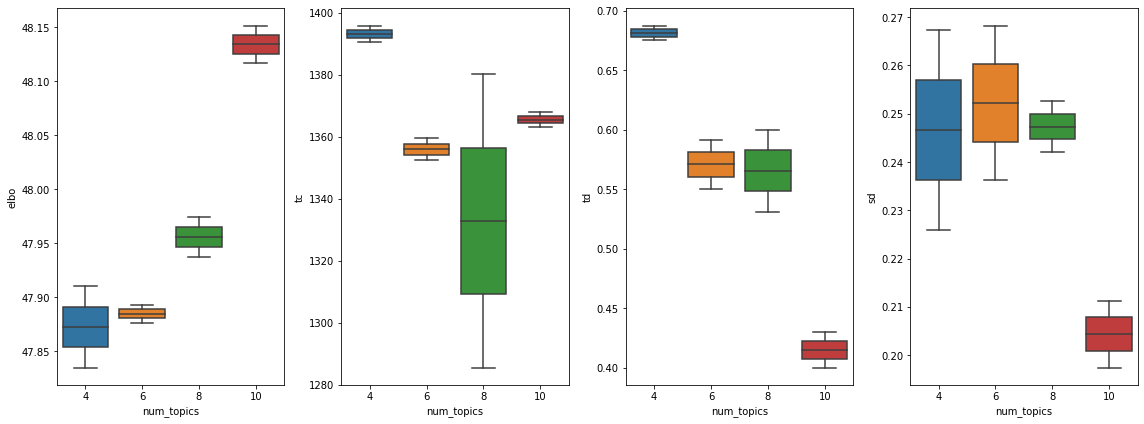

In [ ]:
# plot stats
x_var = "num_topics"
hue_var = None #"embedding_type"

by_cols = ["num_topics"]
rot = 45
fig, ax = plt.subplots(1, 4, figsize=(16, 6))
# df_stats.boxplot(column="elbo", by=by_cols, rot=rot, ax=ax[0])
# df_stats.boxplot(column="tc", by=by_cols, rot=rot, ax=ax[1])
# df_stats.boxplot(column="td", by=by_cols, rot=rot, ax=ax[2])
# df_stats.boxplot(column="sd", by=by_cols, rot=rot, ax=ax[3])
sns.boxplot(data=df_stats, x=x_var, y="elbo", hue=hue_var, ax=ax[0])
sns.boxplot(data=df_stats, x=x_var, y="tc", hue=hue_var, ax=ax[1])
sns.boxplot(data=df_stats, x=x_var, y="td", hue=hue_var, ax=ax[2])
sns.boxplot(data=df_stats, x=x_var, y="sd", hue=hue_var, ax=ax[3])

plt.suptitle("")
plt.tight_layout()
plt.show()